# Capstone Project - The Battle of Neighborhoods (Week 2)

# Toronto City Ice Cream Shop Choice

## 1. Data about the neighborhoods of Toronto City

### Installing and Importing the required Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import numpy as np
import os
from geopy.geocoders import Nominatim

### Scrape the List of postal codes of Canada

In [2]:
list_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(list_url).text
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')

# dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
column_names = ['PostalCode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

# search all the postcode, borough, neighborhood 
for tr_cell in table.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data

df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Data Cleaning

In [3]:
# remove rows where Borough is 'Not assigned'
df = df[df['Borough']!='Not assigned']
df.head()

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
temp_df=df.groupby('PostalCode')['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
temp_df=temp_df.reset_index(drop=False)
temp_df.rename(columns={'Neighborhood':'Neighborhood_joined'},inplace=True)

In [5]:
df_merge = pd.merge(df, temp_df, on='PostalCode')
df_merge.drop(['Neighborhood'],axis=1,inplace=True)
df_merge.drop_duplicates(inplace=True)
df_merge.rename(columns={'Neighborhood_joined':'Neighborhood'},inplace=True)
df_merge.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [6]:
df_merge.shape

(103, 3)

## 2. Geospatial data from Foursquare

In [7]:
def get_geocode(postal_code):
    # initialize your variable to None
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    return latitude,longitude

In [8]:
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [9]:
geo_df.rename(columns={'Postal Code':'PostalCode'},inplace=True)
geo_merged = pd.merge(geo_df, df_merge, on='PostalCode')
geo_data=geo_merged[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]
geo_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [10]:
toronto_data=geo_data[geo_data['Borough'].str.contains("Toronto")]
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [1]:
# @hidden_cell
CLIENT_ID = '2TPWJYHGDGU0F3O0UZIZOMD0QJR2ZBLPDMJJYEQ1I2UARBIJ' # your Foursquare ID
CLIENT_SECRET = 'FT1MTLKTJKN1OVXJLHKIYZBPDJIXZ4EOSYNHHSKNVXRJAPPV' # your Foursquare Secret
VERSION = '20180604'

In [14]:
def get_venues(lat,lng):

    radius=1000
    LIMIT=100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [15]:
# prepare neighborhood list that contains ice cream shop
column_names=['PostalCode', 'Borough', 'Neighborhood', 'ID','Name']
ice_cream_shop_toronto=pd.DataFrame(columns=column_names)
count=1
for row in toronto_data.values.tolist():
    PostalCode, Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    ice_cream_shop=venues[venues['Category']=='Ice Cream Shop']   
    print('(',count,'/',len(toronto_data),')','Ice Cream Shops in '+Neighborhood+', '+Borough+':'+str(len(ice_cream_shop)))
    for restaurant_detail in ice_cream_shop.values.tolist():
        id, name , category=restaurant_detail
        ice_cream_shop_toronto = ice_cream_shop_toronto.append({'PostalCode': PostalCode,
                                                'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 39 ) Ice Cream Shops in The Beaches, East Toronto:1
done
( 2 / 39 ) Ice Cream Shops in The Danforth West, Riverdale, East Toronto:3
done
( 3 / 39 ) Ice Cream Shops in India Bazaar, The Beaches West, East Toronto:1
done
( 4 / 39 ) Ice Cream Shops in Studio District, East Toronto:1
done
( 5 / 39 ) Ice Cream Shops in Lawrence Park, Central Toronto:0
done
( 6 / 39 ) Ice Cream Shops in Davisville North, Central Toronto:0
done
( 7 / 39 ) Ice Cream Shops in North Toronto West,  Lawrence Park, Central Toronto:0
done
( 8 / 39 ) Ice Cream Shops in Davisville, Central Toronto:1
done
( 9 / 39 ) Ice Cream Shops in Moore Park, Summerhill East, Central Toronto:0
done
( 10 / 39 ) Ice Cream Shops in Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park, Central Toronto:0
done
( 11 / 39 ) Ice Cream Shops in Rosedale, Downtown Toronto:0
done
( 12 / 39 ) Ice Cream Shops in St. James Town, Cabbagetown, Downtown Toronto:0
done
( 13 / 39 ) Ice Cream Shops in Church and Wellesley, Downt

In [16]:
ice_cream_shop_toronto.shape

(19, 5)

In [49]:
ice_cream_shop_toronto

,PostalCode,Borough,Neighborhood,ID,Name
0,M4E,East Toronto,The Beaches,4b37c839f964a5200e4625e3,Ed's Real Scoop
1,M4K,East Toronto,"The Danforth West, Riverdale",57799e91498e189817c91ead,La Diperie
2,M4K,East Toronto,"The Danforth West, Riverdale",4dc72844d22dafda2fcf75e6,Dolce Gelato
3,M4K,East Toronto,"The Danforth West, Riverdale",4ade4f8af964a520e27421e3,Dairy Queen
4,M4L,East Toronto,"India Bazaar, The Beaches West",59172e0169e77b035cdbe7bd,Brett's Ice Cream
5,M4M,East Toronto,Studio District,4ad7e958f964a520001021e3,Ed's Real Scoop
6,M4S,Central Toronto,Davisville,4c5f63213986e21eed23924f,Gelato Simply Italian
7,M4Y,Downtown Toronto,Church and Wellesley,4b746c9df964a520c1db2de3,Baskin-Robbins
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",5014414be4b05d9dc85cf8a1,Lick It Gelato
9,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",57802743498ec67ef8812d88,Eva's Original Chimneys


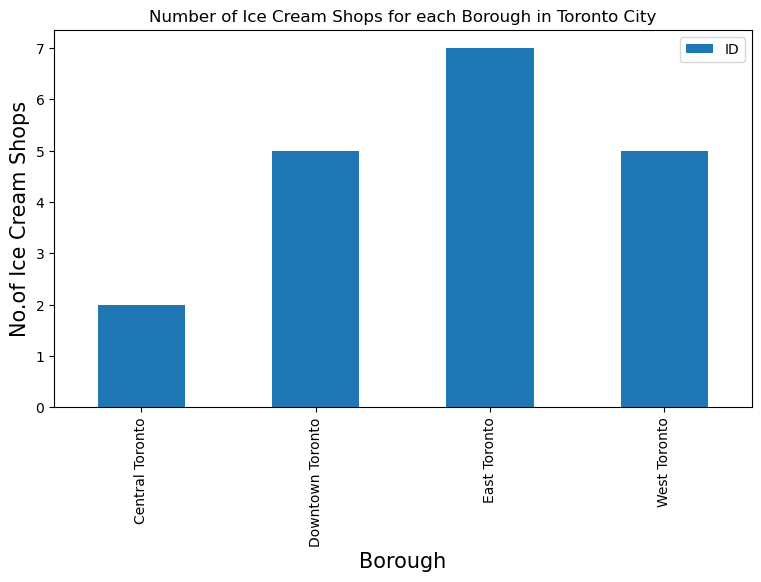

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Ice Cream Shops for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Ice Cream Shops', fontsize=15)
#giving a bar plot
ice_cream_shop_toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

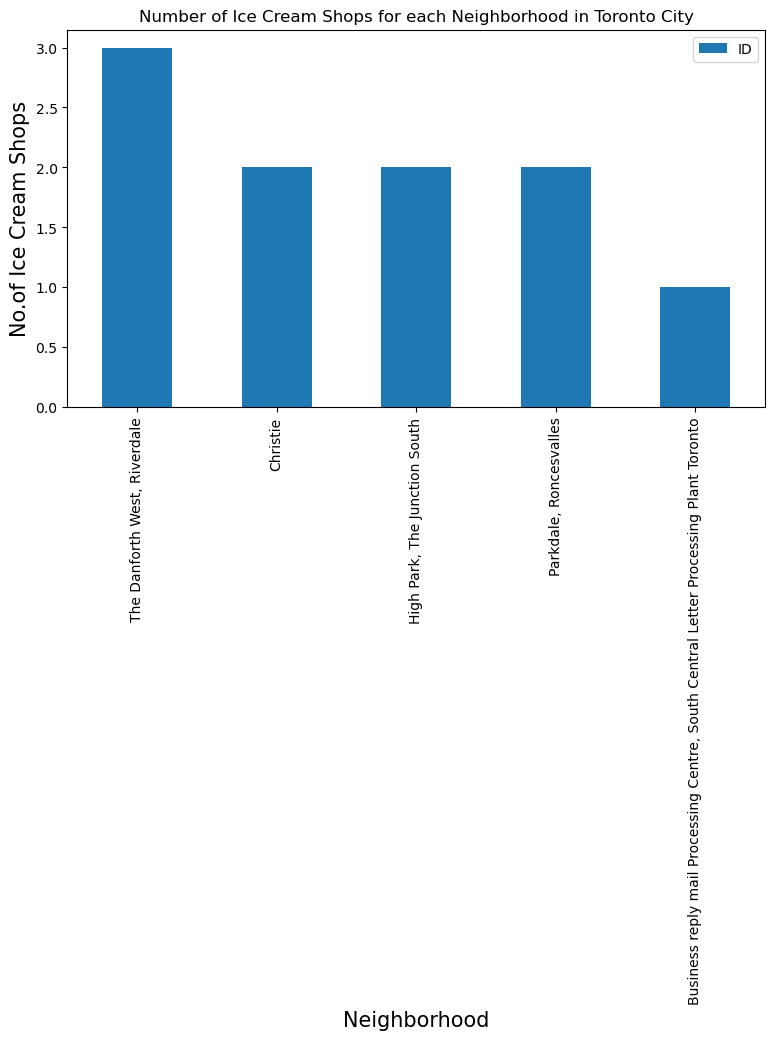

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Ice Cream Shops for each Neighborhood in Toronto City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Ice Cream Shops', fontsize=15)
#giving a bar plot
ice_cream_shop_toronto.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [ ]:
# ice_cream_shop_toronto[ice_cream_shop_toronto['Neighborhood']=='The Danforth West, Riverdale']

In [21]:
def get_venue_details(venue_id):
        
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [22]:
# prepare neighborhood list that contains ice cream shops
column_names=['PostalCode', 'Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
ice_cream_shop_stats_toronto=pd.DataFrame(columns=column_names)
count=1


for row in ice_cream_shop_toronto.values.tolist():
    PostalCode,Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(ice_cream_shop),')','processed')
    ice_cream_shop_stats_toronto = ice_cream_shop_stats_toronto.append({'PostalCode': PostalCode,
                                                'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID             Name  Likes  Rating  Tips
0  4b37c839f964a5200e4625e3  Ed's Real Scoop     59     8.5    30
( 1 / 1 ) processed
                         ID        Name  Likes  Rating  Tips
0  57799e91498e189817c91ead  La Diperie     15     8.1     7
( 2 / 1 ) processed
                         ID          Name  Likes  Rating  Tips
0  4dc72844d22dafda2fcf75e6  Dolce Gelato     54     8.1    22
( 3 / 1 ) processed
                         ID         Name  Likes  Rating  Tips
0  4ade4f8af964a520e27421e3  Dairy Queen     28     7.0    19
( 4 / 1 ) processed
                         ID               Name  Likes  Rating  Tips
0  59172e0169e77b035cdbe7bd  Brett's Ice Cream      9     7.8     3
( 5 / 1 ) processed
                         ID             Name  Likes  Rating  Tips
0  4ad7e958f964a520001021e3  Ed's Real Scoop    108     9.0    70
( 6 / 1 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4c5f63213986e21eed23924f  Gelato 

In [23]:
ice_cream_shop_stats_toronto.head()

,PostalCode,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,M4E,East Toronto,The Beaches,4b37c839f964a5200e4625e3,Ed's Real Scoop,59,8.5,30
1,M4K,East Toronto,"The Danforth West, Riverdale",57799e91498e189817c91ead,La Diperie,15,8.1,7
2,M4K,East Toronto,"The Danforth West, Riverdale",4dc72844d22dafda2fcf75e6,Dolce Gelato,54,8.1,22
3,M4K,East Toronto,"The Danforth West, Riverdale",4ade4f8af964a520e27421e3,Dairy Queen,28,7.0,19
4,M4L,East Toronto,"India Bazaar, The Beaches West",59172e0169e77b035cdbe7bd,Brett's Ice Cream,9,7.8,3


In [24]:
ice_cream_shop_stats_toronto.shape

(19, 8)

In [25]:
ice_cream_shop_toronto.shape

(19, 5)

Let's check the Dtype and correct them.

In [26]:
ice_cream_shop_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    19 non-null     object 
 1   Borough       19 non-null     object 
 2   Neighborhood  19 non-null     object 
 3   ID            19 non-null     object 
 4   Name          19 non-null     object 
 5   Likes         19 non-null     object 
 6   Rating        19 non-null     float64
 7   Tips          19 non-null     object 
dtypes: float64(1), object(7)
memory usage: 1.3+ KB


In [27]:
ice_cream_shop_stats_toronto['Likes']=ice_cream_shop_stats_toronto['Likes'].astype('float64')
ice_cream_shop_stats_toronto['Tips']=ice_cream_shop_stats_toronto['Tips'].astype('float64')

In [28]:
ice_cream_shop_stats_toronto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PostalCode    19 non-null     object 
 1   Borough       19 non-null     object 
 2   Neighborhood  19 non-null     object 
 3   ID            19 non-null     object 
 4   Name          19 non-null     object 
 5   Likes         19 non-null     float64
 6   Rating        19 non-null     float64
 7   Tips          19 non-null     float64
dtypes: float64(3), object(5)
memory usage: 1.3+ KB


Now let's find the most popular Ice Cream Shops.

In [29]:
# ice cream shop with maximum Likes
ice_cream_shop_stats_toronto.iloc[ice_cream_shop_stats_toronto['Likes'].idxmax()]

PostalCode                               M6J
Borough                         West Toronto
Neighborhood        Little Portugal, Trinity
ID                  537bd61f498e0dae73728800
Name            Bang Bang Ice Cream & Bakery
Likes                                    272
Rating                                   8.9
Tips                                      97
Name: 13, dtype: object

In [30]:
# ice cream shop with maximum Rating
ice_cream_shop_stats_toronto.iloc[ice_cream_shop_stats_toronto['Rating'].idxmax()]

PostalCode                           M4M
Borough                     East Toronto
Neighborhood             Studio District
ID              4ad7e958f964a520001021e3
Name                     Ed's Real Scoop
Likes                                108
Rating                                 9
Tips                                  70
Name: 5, dtype: object

In [31]:
# ice cream shop with maximum Tips
ice_cream_shop_stats_toronto.iloc[ice_cream_shop_stats_toronto['Tips'].idxmax()]

PostalCode                               M6J
Borough                         West Toronto
Neighborhood        Little Portugal, Trinity
ID                  537bd61f498e0dae73728800
Name            Bang Bang Ice Cream & Bakery
Likes                                    272
Rating                                   8.9
Tips                                      97
Name: 13, dtype: object

Let's do some plotting in the neighborhoods of Toronto.

In [51]:
toronto_neighborhood_stats=ice_cream_shop_stats_toronto.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
toronto_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [52]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
9,Studio District,9.000000
7,"Little Portugal, Trinity",8.900000
11,The Beaches,8.500000
4,"Harbourfront East, Union Station, Toronto Islands",8.300000
10,"The Annex, North Midtown, Yorkville",8.000000
13,"University of Toronto, Harbord",8.000000
0,"Business reply mail Processing Centre, South C...",7.800000
6,"India Bazaar, The Beaches West",7.800000
12,"The Danforth West, Riverdale",7.733333
5,"High Park, The Junction South",7.650000


In [53]:
toronto_borough_stats=ice_cream_shop_stats_toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
toronto_borough_stats.columns=['Borough','Average Rating']

In [54]:
toronto_borough_stats.sort_values(['Average Rating'],ascending=False)

,Borough,Average Rating
2,East Toronto,8.042857
3,West Toronto,7.780000
1,Downtown Toronto,7.740000
0,Central Toronto,7.500000


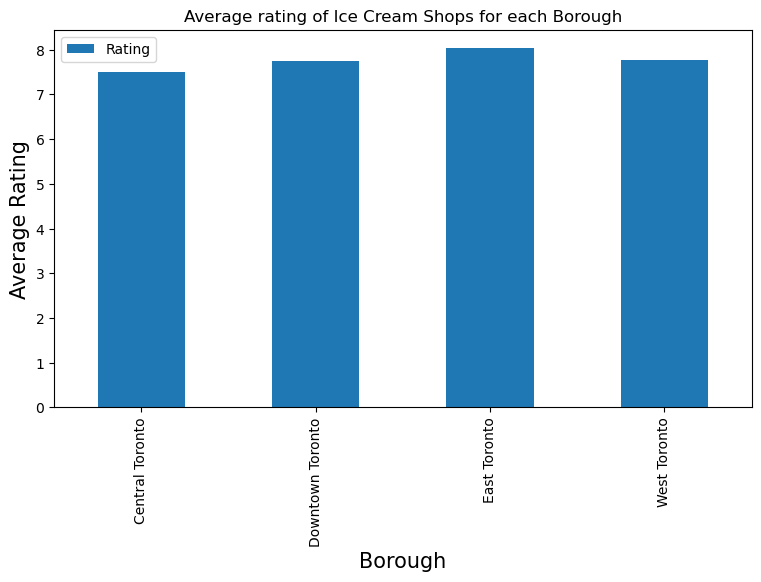

In [37]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Ice Cream Shops for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
ice_cream_shop_stats_toronto.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [38]:
toronto_neighborhood_stats=toronto_neighborhood_stats[toronto_neighborhood_stats['Average Rating']>=8.0]

In [40]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
9,Studio District,9.0
7,"Little Portugal, Trinity",8.9
11,The Beaches,8.5
4,"Harbourfront East, Union Station, Toronto Islands",8.3
10,"The Annex, North Midtown, Yorkville",8.0
13,"University of Toronto, Harbord",8.0


In [41]:
toronto_neighborhood_stats=pd.merge(toronto_neighborhood_stats,toronto_data, on='Neighborhood')

In [42]:
toronto_neighborhood_stats=toronto_neighborhood_stats[['PostalCode','Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [44]:
toronto_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Average Rating
2,M4M,East Toronto,Studio District,43.659526,-79.340923,9.0
1,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,8.9
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,8.5
0,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,8.3
3,M5R,Central Toronto,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,8.0
5,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,8.0


In [45]:
!pip install folium

In [47]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [48]:
import folium

# create map and display it
toronto_map = folium.Map(location=[43.6534817, -79.3839347], zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in toronto_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

toronto_neighborhood_stats['Label']=toronto_neighborhood_stats['Neighborhood']+', '+toronto_neighborhood_stats['Borough']+'('+toronto_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in toronto_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(toronto_map)        
# add incidents to map
toronto_map.add_child(incidents)

## Conclusion

The Ice Cream Shop with maximum Likes and maximum Tips is Bang Bang Ice Cream & Bakery in Little Portugal, Trinity; the one with maximum Rating is Ed's Real Scoop in Studio City.

The Borough with more Ice Cream Shops is East Toronto, and the Neighborhood with more Ice Cream Shops is the Danforth West, Riverdale.

There are not many Ice Cream Shops in the city of Toronto. Opening an authentic Gelateria and having a success are considerably possible.